#### 0. Introducción.

 El presente ejercicio tiene como objetivo abordar la problemática de análisis de <b>outliers</b> enfocado al fraude bancario. Para lograr acabo esta actividad se hará uso de una de las competencias publicadas en la plataforma de Kaggle, la competencia en cuestión es un publicación de los investigdoes de la IEEE Computational Intelligence Society (IEEE-CIS) quienes se han asociado con la empresa de servicios de pago líder en el mundo, Vesta Corporation, en busca de las mejores soluciones para la industria de prevención del fraude.

IEEE-CIS trabaja en una variedad de áreas de inteligencia artificial y aprendizaje automático, incluidas redes neuronales profundas, sistemas difusos, computación evolutiva e inteligencia de enjambre. Y a través de esta competencia busca que los usuarios interesados comparen modelos de aprendizaje automático en un desafiante conjunto de datos a gran escala. Los datos provienen de las transacciones de comercio electrónico del mundo real de Vesta y contienen una amplia gama de características, desde el tipo de dispositivo hasta las características del producto.

El objetivo final, es mejorar la eficacia de las alertas de transacciones fraudulentas para millones de personas en todo el mundo, ayudando a cientos de miles de empresas y usuarios a reducir sus pérdidas por fraude.

#### 1. Carga de la información.

1.1 Se importan las librerias o funciones a ocupar a lo largo de la libreta, así como la ruta con los datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

In [2]:
print(os.listdir('./data'))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


#### 2. Análisis exploratorio de datos. 

- El objetivo que se tiene es poder estimar la probabilidad de que una transacción sea fraudulenta a manera que la probabilidad sea alta cuando la variable binaria "isFraud" sea 1 y baja para caso contrario.


La información esta partida en las tablas: identity (train y test) y transaction (train y test), se pueden cruzar por TransactionID. **¡OJO! No todas las transacciones tienen información de identidad. ***  


2.1 Descripción y observación de los datos.

- La siguiente función tiene como objetivo permitir al usuario tener un resumen descriptivo del dataframe seleccionado, así como la observación de algunas de las entradas del mismo.

In [3]:
# Función para leer y hacer una primera revisión de los datos
def read_and_interpret_data(filename):
    path = './data'
    df = pd.read_csv('{0}/{1}'.format(path,filename))
    print("~~~~~~Perfil de los datos~~~~~~ : ",df.shape)
    print("~~~~~~Columnas con su datatype~~~~~~ : ")
    print(df.info())
    print("~~~~~~Primeros datos~~~~~~ : ")
    print(df.head())
    print("~~~~~~Últimos datos~~~~~~ : ")
    print(df.tail())
    print("~~~~~~Descripción de los datos~~~~~~ : ")
    print(df.describe())
    print("~~~~~~Datos faltantes~~~~~~ : ")
    print(df.isna().sum())
    if 'timestamp' in df.columns: 
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = "%Y-%m-%d %H:%M:%S")
        print("~~~~~~Años de los datos~~~~~~ :")
        print(df.timestamp.dt.year.unique())
    return df

- De momento se trabajara únicamentecon los archivos de entrenamiento.

El dataframe "identiy" contiene 41 variables con información de la conexión de red (IP, ISP, Proxy, etc.) y firma digital (UA/navegador/OS/versión, etc.) asociada con las transacciones. Dichos datos fueron recolectados por el sistema de protección contra fraudes de Vesta y los socios de seguridad digital.

 Las varaiblescategóricas son las siguientes:
 - DeviceType
 - DeviceInfo
 - id_12 a id_38


In [4]:
df_train_id = read_and_interpret_data('train_identity.csv')

~~~~~~Perfil de los datos~~~~~~ :  (144233, 41)
~~~~~~Columnas con su datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null 

El dataframe "transaction" contiene 394 variables con la información detallada de las transacciones, destacan las siguientes variables:

- TransactionDT: timedelta de una fecha y hora de referencia determinada (no una marca de tiempo real) 

- TransactionAMT: monto del pago de la transacción en USD 

- ProductCD: código de producto, el producto para cada transacción “No es necesario que el producto sea un 'producto' real (como un artículo que se agregará al carrito de compras). Podría ser cualquier tipo de servicio.

- card1 - card6: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.

- addr : dirección, "ambas direcciones son para el comprador.
        addr1 como región de facturación
        addr2 como país de facturación”

- dist: distancia "distancias entre (no limitadas) la dirección de facturación, la dirección postal, el código postal, la dirección IP, el área telefónica, etc."

- P_ y (R__) emaildomain: dominio de correo electrónico del comprador y del destinatario “ciertas transacciones no necesitan un destinatario, por lo que R_emaildomain es nulo”.

- C1-C14: conteo, como cuántas direcciones se encuentran asociadas con la tarjeta de pago, etc. El significado real está enmascarado. 

- D1-D15: timedelta, como días entre transacciones anteriores, etc.

- M1-M9: coincidencia, como nombres en la tarjeta y dirección, etc.

- Vxxx: características completas diseñadas por Vesta, que incluyen clasificación, conteo y otras relaciones de entidad. "Todas las funciones de Vesta se derivaron como numéricas. Algunas de ellas son recuentos de órdenes dentro de un agrupamiento, un período de tiempo o una condición, por lo que el valor es finito y tiene una ordenación (o clasificación)".

In [5]:
df_train_tr = read_and_interpret_data('train_transaction.csv')

~~~~~~Perfil de los datos~~~~~~ :  (590540, 394)
~~~~~~Columnas con su datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None
~~~~~~Primeros datos~~~~~~ : 
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  Na

2.2 Optimización del uso de memoria 

- Ante el enorme reto que significa modelar datasets cuya información ronda 1500MB, a continuación se define y posteriormente se aplica una función que permitira reducir el tamaño del formato default otorgado por pandas al cargar cada uno de los dataframes, esto con la finalidad de lograr una manipulación más sencilla y rápida de la información.

In [6]:
#Se procede a guardar cada uno de los datasets.
DATA_PATH = './data/'
train_identity = pd.read_csv(DATA_PATH + 'train_identity.csv')
train_transaction = pd.read_csv(DATA_PATH +'train_transaction.csv')


In [7]:
# Definición de la función para la reducción de uso de memoria
def reduce_mem_usage(df):
    ### itera a través de todas las columnas de un "dataframe" y modifica el tipo de datos
    ### para reducir el uso de la memoria.        ###
    # Se imprime el tamaño inicial del dataframe.
    start_mem = df.memory_usage().sum() / 1024**2
    print('El uso de memoria del "dataframe" es {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Si el tipo de dato es númerico se reduce el espacio al mínimo tamaño posible que permite almacenar 
            # el dato más grande o pequeño de la columna
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            #Si el tipo de dato es caracter, se transforma el tipo de dato a categoríco o categoría.
        else:
            df[col] = df[col].astype('category')
    # Se imprime el resultado final.
    end_mem = df.memory_usage().sum() / 1024**2
    print('El uso de memoria después de la optimización es: {:.2f} MB'.format(end_mem))
    print('Disminuido en {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
#Se aplica la función en los diversos dataframes definidos.
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

El uso de memoria del "dataframe" es 45.12 MB
El uso de memoria después de la optimización es: 10.00 MB
Disminuido en 77.8%
El uso de memoria del "dataframe" es 1775.15 MB
El uso de memoria después de la optimización es: 487.16 MB
Disminuido en 72.6%


2.3 Análisis de la información.

- A continuación se procede al análisis visual de la información, haciendo uso de diversos gráficos: histogramas, scatter plots o box plots. Con el objetivo de identificar patrones o características de población que nos ayuden a seleccionar el modelo más adecuado para nuestro problema.

In [9]:
def plot_hist(df,var_name):
    plt.figure(figsize=(17,8))
    plt.hist(df[var_name],bins = 50)
    plt.title(f"Histogram - {var_name}")
    plt.show()

- Como era de esperarse el problema presenta en su varaible objetivo una  distribución totalmente desbalanceada donde solo el 3.5% de las operaciones fueron marcadas como fraudulentas.

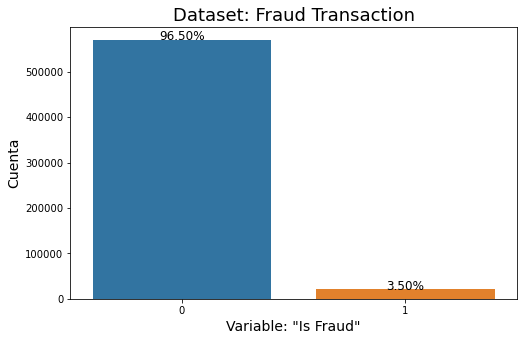

In [10]:
fig, ax  = plt.subplots(figsize=(8, 5))
sns.countplot(x='isFraud', data=train_transaction, ax=ax)
ax.set_title('Dataset: Fraud Transaction', fontsize=18)
ax.set_xlabel('Variable: "Is Fraud"', fontsize=14)
ax.set_ylabel('Cuenta', fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            f'{height/train_transaction.shape[0] * 100:.2f}%',
            ha='center', fontsize=12)

“El primer valor de TransactionDT es 86400, que corresponde a la cantidad de segundos en un día (60 * 60 * 24 = 86400), así que creo que la unidad es segundos. Usando esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, que correspondería al día 183”.

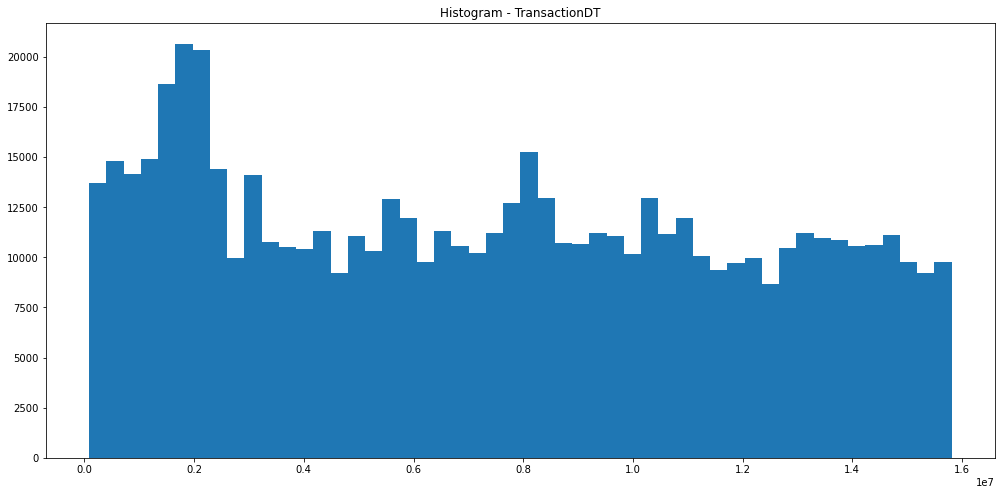

In [11]:
plot_hist(train_transaction, 'TransactionDT')

- Con el objetivo de interpretar de manera más adecuada se suaviza los montos de las transacciones.

Text(0, 0.5, 'Frequency')

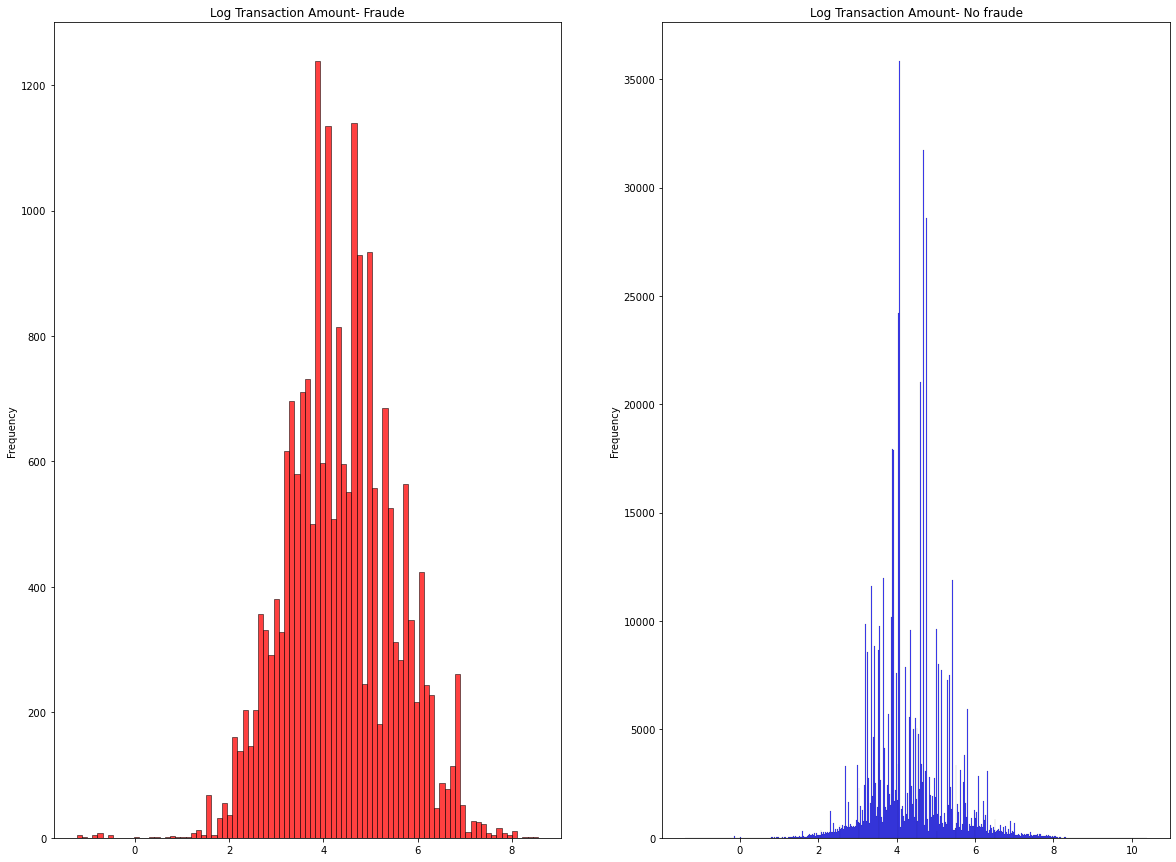

In [12]:

fig, ax = plt.subplots(1,2, figsize=(20, 15))

fraud_amt = train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values
non_fraud_amt = train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.histplot(x = np.log(fraud_amt), ax=ax[0], color='red')
ax[0].set_title("Log Transaction Amount- Fraude")
ax[0].set_ylabel("Frequency")

sns.histplot(x = np.log(non_fraud_amt), ax=ax[1], color = 'blue')
ax[1].set_title("Log Transaction Amount- No fraude")
ax[1].set_ylabel("Frequency")


<AxesSubplot:xlabel='TransactionDT', ylabel='TransactionAmt'>

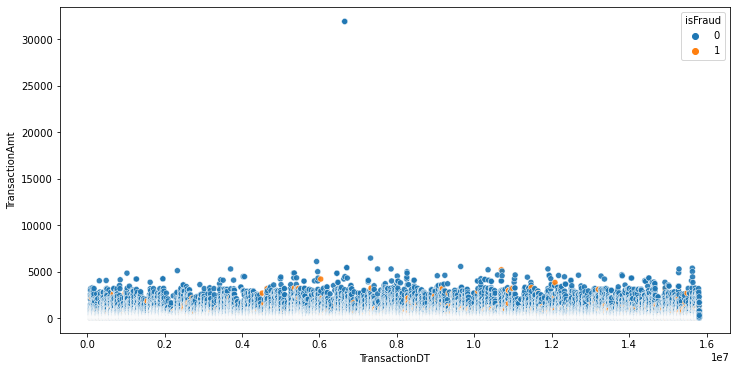

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot( x= train_transaction['TransactionDT'], y= train_transaction['TransactionAmt'],
            alpha=0.9, hue=train_transaction['isFraud'])

In [14]:
def porcentaje(grafica, var):
    total = len(var)
    for p in grafica.patches:
        pct = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        grafica.annotate(pct, (x, y), size = 12)
    plt.show()


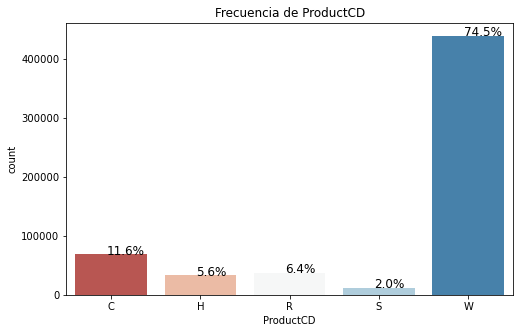

In [15]:
cmap=sns.color_palette("RdBu", n_colors=7)
plt.figure(figsize= (8,5))
ax = sns.countplot(data=train_transaction, x='ProductCD', palette="RdBu")
plt.title('Frecuencia de ProductCD')
porcentaje(ax, train_transaction['ProductCD'])

Características de la tarjeta

- De acuerdo con la página de descripción de datos de la competencia, hay 6 características de tarjeta diferentes, card1 a card6. Sin embargo, card1, card2, card3 y card5 se codifican como valor numérico. No se nos dice el significado exacto de las características de las características de la tarjeta. Esta puede ser la información de la tarjeta de pago, como el tipo de tarjeta, la categoría de la tarjeta, etc.

- Muchos valores de card3 y card5 tienen frecuencias bajas.

- En la tarjeta 3, 150 y 185 son los valores más frecuentes en la columna. Tenemos 2.4% de fraude en 150 y 13% de fraude en valor 185

- En card5, los valores más frecuentes son 226, 224, 166 que representa el 73% de los datos.

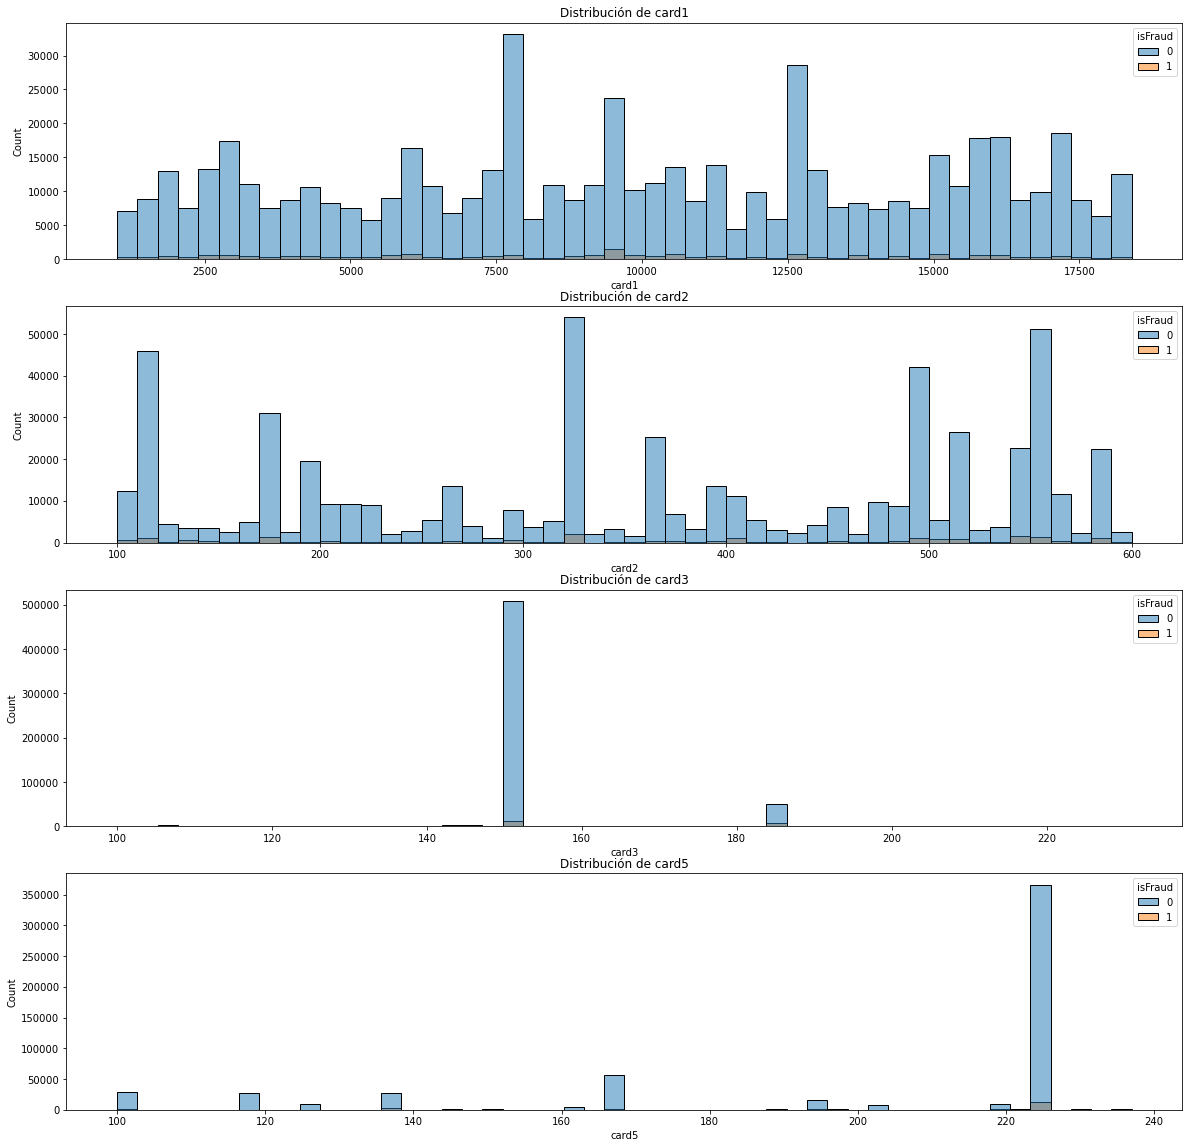

In [16]:
fig, ax = plt.subplots(4, figsize=(20, 20))
cards_col = ['card1', 'card2', 'card3', 'card5']
for i, card in enumerate(cards_col):
    sns.histplot(data = train_transaction, x=card, hue='isFraud', bins=50,
    legend= 'isFraud', ax=ax[i])
    ax[i].set_title("Distribución de "+(card))

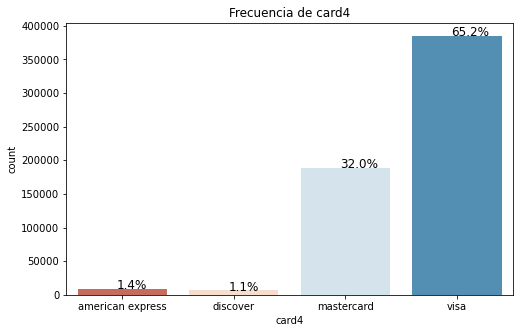

In [17]:
cmap=sns.color_palette("RdBu", n_colors=7)
plt.figure(figsize= (8,5))
ax = sns.countplot(data=train_transaction, x='card4', palette="RdBu")
plt.title('Frecuencia de card4')
porcentaje(ax, train_transaction['card4'])

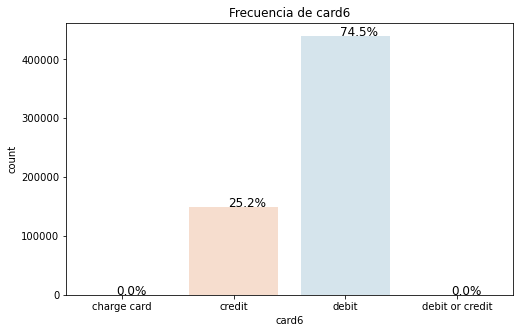

In [18]:
cmap=sns.color_palette("RdBu", n_colors=7)
plt.figure(figsize= (8,5))
ax = sns.countplot(data=train_transaction, x='card6', palette="RdBu")
plt.title('Frecuencia de card6')
porcentaje(ax, train_transaction['card6'])

Características de los dominios de correo.

P_emaildomain es el dominio de correo electrónico del comprador y R_emaildomain es el dominio de correo electrónico del destinatario, se agrupan los dominios de correo electrónico por proveedor de servicios que tienen menos de 1000 entradas como 'Otros.

 - La mayoría de los P_emaildomain de la transacción son de Google, Yahoo y Microsoft.

 - Microsoft P_emaildomain tiene el porcentaje de fraude más alto en comparación con otros dominios.

 - La mayoría de los R_emaildomain de la transacción son de Google, correo anónimo, Yahoo y Microsoft.

 - R_emaildomain tiene más valores faltantes que P_emaildomain. 

In [19]:
a = train_transaction['P_emaildomain'].value_counts()
b = a.loc[lambda x : (x<1000)].index.tolist()
train_transaction['GP_emaildomain'] = np.where(train_transaction['P_emaildomain'].isin(b),
                                                 "Other", train_transaction['P_emaildomain'] )

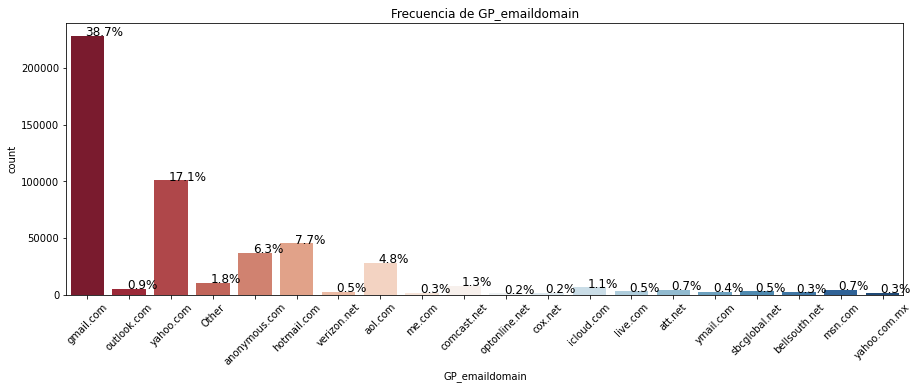

In [20]:
cmap=sns.color_palette("RdBu", n_colors=7)
plt.figure(figsize= (15,5))
ax = sns.countplot(data=train_transaction, x='GP_emaildomain', palette="RdBu")
plt.xticks(rotation=45)
plt.title('Frecuencia de GP_emaildomain')
porcentaje(ax, train_transaction['GP_emaildomain'])

In [21]:
a = train_transaction['R_emaildomain'].value_counts()
b = a.loc[lambda x : (x<1000)].index.tolist()
train_transaction['GR_emaildomain'] = np.where(train_transaction['R_emaildomain'].isin(b),
                                                 "Other", train_transaction['R_emaildomain'] )

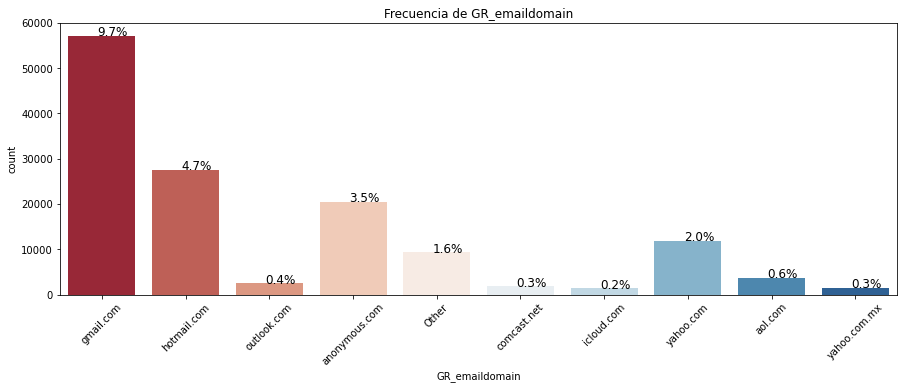

In [22]:
cmap=sns.color_palette("RdBu", n_colors=7)
plt.figure(figsize= (15,5))
ax = sns.countplot(data=train_transaction, x='GR_emaildomain', palette="RdBu")
plt.xticks(rotation=45)
plt.title('Frecuencia de GR_emaildomain')
porcentaje(ax, train_transaction['GR_emaildomain'])

Características C1-C14
 - C1-C14: El significado real está enmascarado.

Excepto por C3, que tiene una cantidad significativamente menor que las otras características de C. El resto de las características de C exhiben el mismo tipo de patrones anuales. 

<AxesSubplot:>

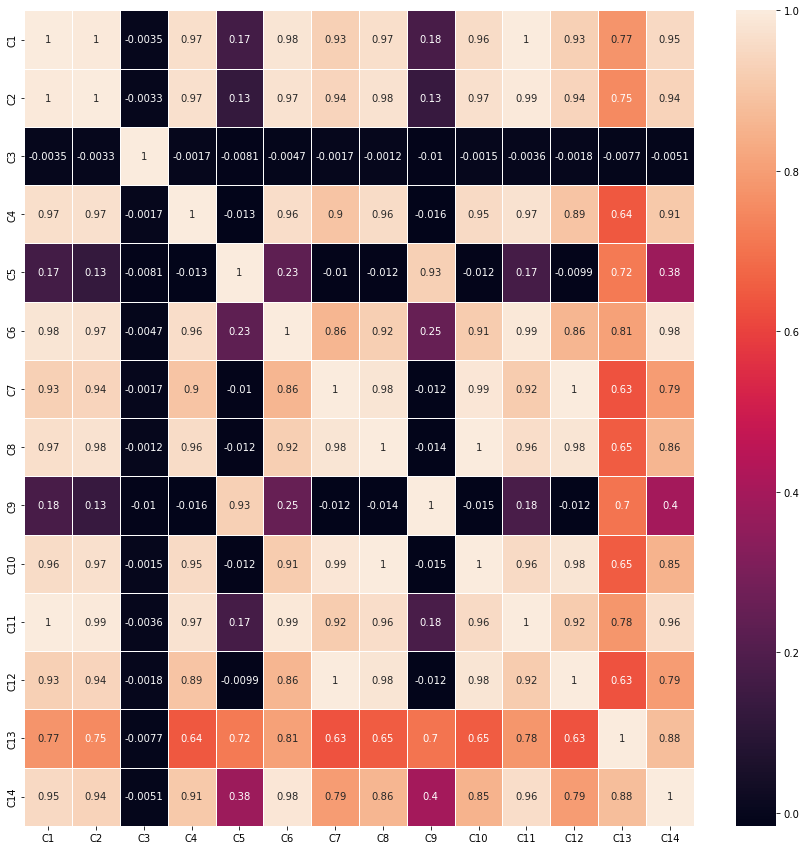

In [23]:

corr = train_transaction.iloc[:, 17:31].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)


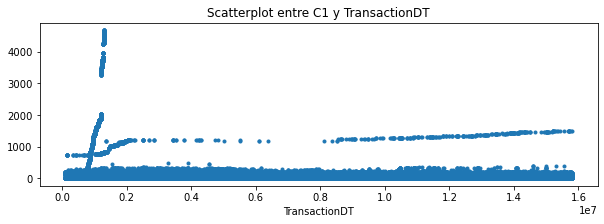

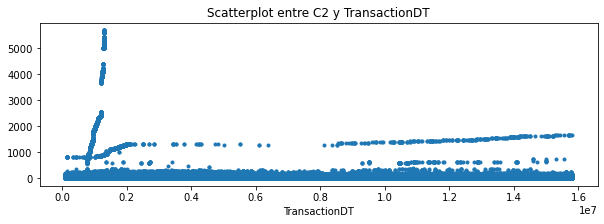

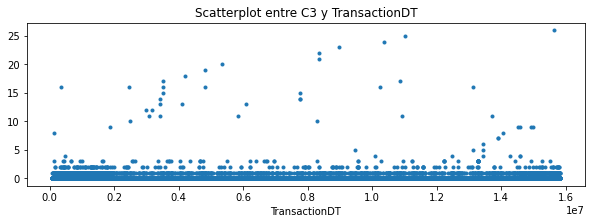

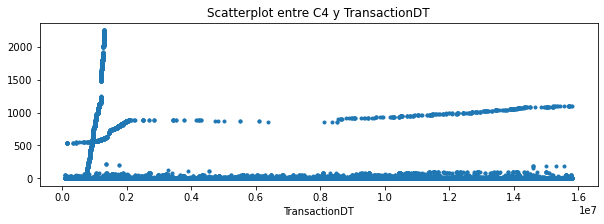

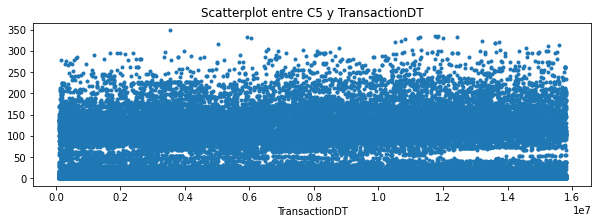

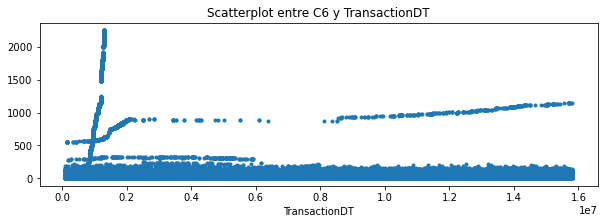

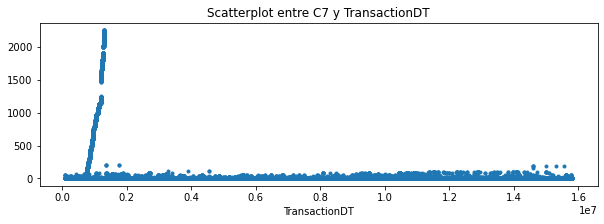

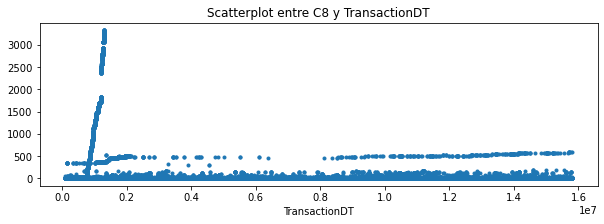

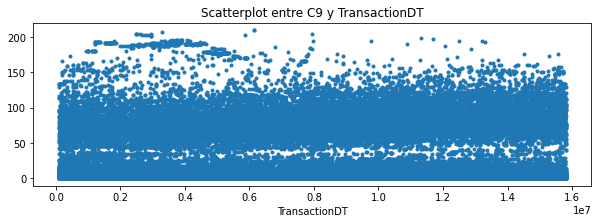

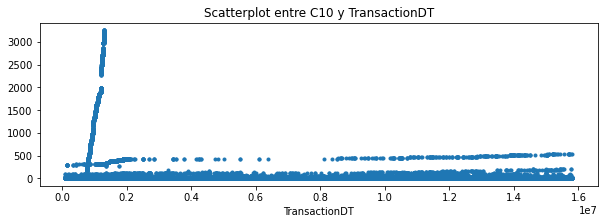

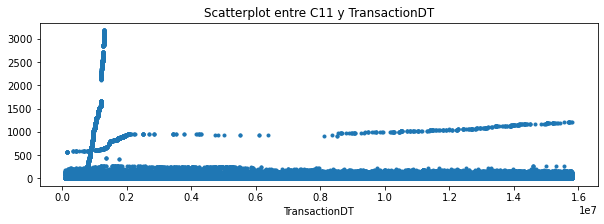

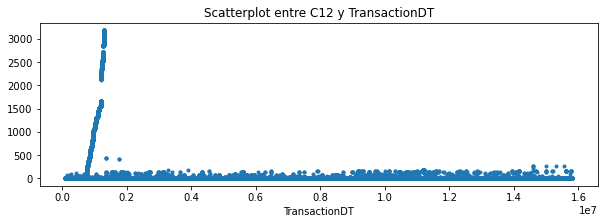

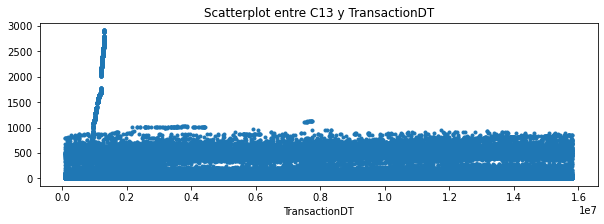

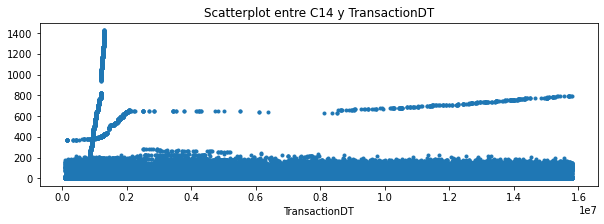

In [24]:
c_features = list(train_transaction.columns[17:31])
for i in c_features:
    train_transaction.set_index('TransactionDT')[i] \
    .plot(style='.', title=f'Scatterplot entre {i} y TransactionDT',
          figsize=(10, 3))
    plt.show()
              